In [1]:
import matplotlib

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.path import Path
from tqdm.notebook import tqdm

import functools

### General Setting

In [2]:
RUN_NAIVE_GRADIENT = True
RUN_INCLUDE_GRADIENT = True

RUN_TEXTURE_FLATTENING = True
RUN_LOCAL_ILLUMINATION_CHANGES = True
RUN_LOCAL_COLOR_CHANGE = True
RUN_SEAMLESS_TILING = True

### Helper Functions

#### Index Manipulation

In [3]:
def valid_index(im, point):
    return 0 <= point[1] < im.shape[0] and 0 <= point[0] < im.shape[1]

def get_neighbours(point):
    x, y = point
    return [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

def clip_coordinate(point, im_shape):
    x = np.clip(point[0], 0, im_shape[1]-1)
    y = np.clip(point[1], 0, im_shape[0]-1)
    return (x, y)

In [4]:
def find_center(path):
    path = np.asarray(path)
    xmin = path[:, 0].min()
    xmax = path[:, 0].max()
    ymin = path[:, 1].min()
    ymax = path[:, 1].max()
    return (xmin + xmax) / 2, (ymin + ymax) / 2

In [5]:
def get_path_transform(old_path, new_center):
    if len(old_path) <= 0:
        raise ValueError('Empty path')

    old_center = find_center(old_path)
    
    xshift = int(round(new_center[0] - old_center[0]))
    yshift = int(round(new_center[1] - old_center[1]))
    
    def old2new(old_point):
        return old_point[0]+xshift, old_point[1]+yshift
    
    def new2old(new_point):
        return new_point[0]-xshift, new_point[1]-yshift
    
    return old2new, new2old

In [6]:
def plot_path(path, last_dash=False, **kwargs):
    path = np.asarray(path)
    
    if 'marker' not in kwargs:
        kwargs['marker'] = 'x'
        
    if 'color' not in kwargs:
        kwargs['color'] = 'red'
    
    plt.plot(path[:, 0], path[:, 1], **kwargs)
    
    if len(path) > 1:
        if 'linestyle' not in kwargs:
            kwargs['linestyle'] = '--' if last_dash else '-'
        # connect last to first
        plt.plot([path[-1, 0], path[0, 0]], [path[-1, 1], path[0, 1]], **kwargs)

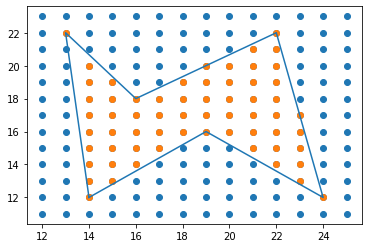

In [7]:
%matplotlib inline

def find_all_enclosed_points(path):
    if len(path) <= 0:
        raise ValueError('Empty path')
        
    arr = np.asarray(path)
    xmin = arr[:, 0].min()
    xmax = arr[:, 0].max()
    ymin = arr[:, 1].min()
    ymax = arr[:, 1].max()
    
    x, y = np.mgrid[xmin:xmax+1, ymin:ymax+1]
    points = np.vstack((x.ravel(), y.ravel())).T
    grid = Path(path).contains_points(points, radius=-1e-4)

    return list(map(tuple, points[grid].round().astype(int)))


# verify find_all_enclosed_points implementation

shape = np.array([
    [14, 12],
    [13, 22],
    [16, 18],
    [22, 22],
    [24, 12],
    [19, 16]
])

plt.plot(
    np.hstack((shape[:, 0], shape[0,0])), # connect last to first point
    np.hstack((shape[:, 1], shape[0,1]))
)
pts = np.asarray(find_all_enclosed_points(shape))
plt.scatter(*np.mgrid[
    shape[:,0].min()-1:shape[:,0].max()+2,
    shape[:,1].min()-1:shape[:,1].max()+2
])
plt.scatter(pts[:, 0], pts[:, 1])
plt.show()

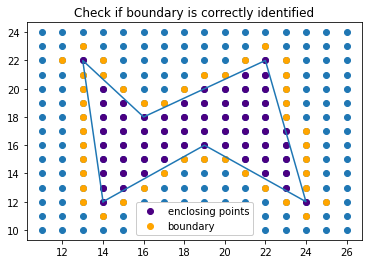

In [8]:
%matplotlib inline

def get_boundaries(points):
    point_set = set(map(tuple, points))
    boundaries = set()
    for point in points:
        for neighbour in get_neighbours(point):
            if neighbour not in point_set:
                boundaries.add(neighbour)
    return boundaries


# verify get_boundaries implementation

shape = np.array([
    [14, 12],
    [13, 22],
    [16, 18],
    [22, 22],
    [24, 12],
    [19, 16]
])

plt.plot(
    np.hstack((shape[:, 0], shape[0,0])), # connect last to first point
    np.hstack((shape[:, 1], shape[0,1]))
)
pts = np.asarray(find_all_enclosed_points(shape))
plt.scatter(*np.mgrid[
    shape[:,0].min()-2:shape[:,0].max()+3,
    shape[:,1].min()-2:shape[:,1].max()+3
])
plt.scatter(pts[:, 0], pts[:, 1], c='indigo', label='enclosing points')

boundaries = np.asarray(list(get_boundaries(pts)))

plt.scatter(boundaries[:, 0], boundaries[:, 1], c='orange', label='boundary')
plt.title('Check if boundary is correctly identified')
plt.legend().get_frame().set_alpha(None)
plt.show()

#### IO

In [9]:
def read_image(path, size=None, grayscale=False, auto_resize=True):
    im = plt.imread(path)
    if size is not None:
        im = cv.resize(im, size)
    elif auto_resize:
        if im.shape[0] > 1000 and im.shape[1] > 1000:
            im = cv.resize(im, (im.shape[1]//10, im.shape[0]//10))
    if grayscale:
        im = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
    return im

In [10]:
def get_image_path_from_user(im, n=None, hint='', pointer_path=None):
    
    fig = plt.figure(figsize=(8, 12))

    points = []
    
    def redraw():
        
        plt.clf()
        
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(im)

        title = f"""
        [add]: left click
        [remove]: right click
        [finish]: middle click
        Note: dotted line is automatically added
        Hint: {hint}
        """
        plt.title(title)
        
        if len(points) > 0:
            plot_path(points, last_dash=True, marker='x', color='red')
            
        if pointer_path is not None and len(points) > 0:
            src2dst, dst2src = get_path_transform(pointer_path, points[-1])
            new_path = np.asarray(list(map(src2dst, pointer_path)))
            plot_path(new_path, marker='o', color='red', linestyle='-.')
            
        fig.canvas.draw()

    def end():
        fig.canvas.mpl_disconnect(cid)
        plt.close('all')
        
    def onclick(event):
        nonlocal points
        if event.button == plt.MouseButton.LEFT:
            ix, iy = event.xdata, event.ydata
            if ix is not None and iy is not None:  # if user did not click outside of image
                points.append((ix, iy))
                if n and n > 0 and len(points) >= n:  # clip any extra points
                    points = points[-n:]
                redraw()
        elif event.button == plt.MouseButton.RIGHT:
            points.pop()
            redraw()
        if event.button == plt.MouseButton.MIDDLE:
            end()

    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    redraw()
    plt.pause(0.1)
    plt.show(block=True)
    
    if n is not None and len(points) != n:
        raise ValueError(f'Not enough points selected, selected={len(points)}, required={n}')
    
    return np.asarray(points)

In [11]:
def plot_images(images, paths, titles, figsize=None, subplot=None):
    if subplot is None:
        subplot = (1, len(images))
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    for i, (im, title, path) in enumerate(zip(images, titles, paths), 1):
        plt.subplot(*subplot, i)
        cmap = 'gray' if im.ndim == 2 else None
        plt.imshow(im, cmap=cmap)
        if path is not None:
            plot_path(path)
        plt.title(title)
        
    plt.tight_layout()

#### Laplacian & Gradient Matrix Construction

In [12]:
def lapl_matrix(points):
    A = sparse.lil_matrix((len(points), len(points)))
    A.setdiag(4)  # 4 for current points
    point2index = {point: i for i, point in enumerate(points)}
    for i, point in enumerate(points):
        for neighbour in get_neighbours(point):
            if neighbour in point2index:
                A[i, point2index[neighbour]] = -1  # -1 for each neighbour
            else:
                # boundary
                # do nothing here assume zero padding
                pass
    return A

def grad_matrix(im, points, grad_fun=None, boundary_fun=None):
    b = np.zeros(len(points), dtype=float)
    boundaries = get_boundaries(points)
    for i, point in enumerate(points):
        if grad_fun is not None:
            b[i] = grad_fun(point)  # find the gradient of the current location
        for neighbour in get_neighbours(point):
            if neighbour in boundaries:  # set the value at the boundary so that we get color after minimization
                if boundary_fun is not None:
                    b[i] += boundary_fun(im, point, neighbour)
                else:
                    neighbour = clip_coordinate(neighbour, im.shape)
                    b[i] += im[neighbour[1], neighbour[0]]
    return b

#### Misc

In [13]:
def assign_color(im, channel, points, colors):
    if im.dtype == np.uint8:
        color_min = 0
        color_max = 255
    else:
        color_min = 0
        color_max = 1
        
    for pt, color in zip(points, colors):
        im[pt[1], pt[0], channel] = np.clip(color, color_min, color_max)

## Naive Filling

In [14]:
def naive_filling_experiment(im, hint='select a region from low frequency image'):

    path = get_image_path_from_user(im, hint=hint)
    
    points = find_all_enclosed_points(path)

    A = lapl_matrix(points)
    
    if im.ndim == 2:
        im = im[..., np.newaxis]
    
    result = np.copy(im)
    for channel in range(im.shape[2]):
        channel_im = im[:, :, channel]
        
        b = grad_matrix(channel_im, points, grad_fun=None)

        solved_color = spsolve(A.tocsr(), b)

        assign_color(result, channel, points, solved_color)
        
    return result, path

In [15]:
%matplotlib notebook
matplotlib.use("TkAgg")

if RUN_NAIVE_GRADIENT:

    low_im = read_image('low_freq.jpg')
    high_im = read_image('high_freq.jpg')
    
    low_filled_im, low_path = naive_filling_experiment(low_im, 'select a region from low frequency image')
    high_filled_im, high_path = naive_filling_experiment(high_im, 'select a region from high frequency image')

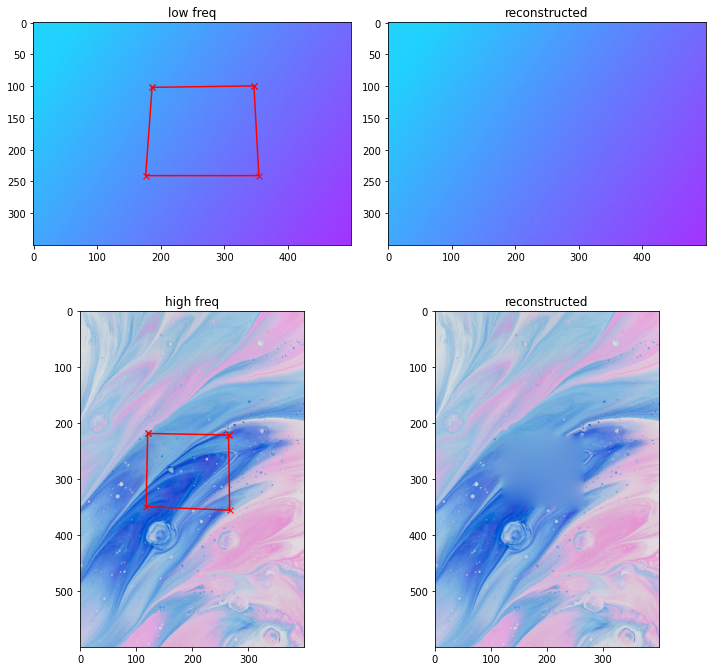

In [16]:
%matplotlib inline

if RUN_NAIVE_GRADIENT:
    
    plot_images(
        images=[low_im, low_filled_im, high_im, high_filled_im],
        paths=[low_path, None, high_path, None],
        titles=['low freq', 'reconstructed', 'high freq', 'reconstructed'],
        figsize=(10, 10),
        subplot=(2, 2)
    )

We can see that this works well for low frequency images, but performs poorly for image contains many high frequency components (edges).

## Include gradient at the region

In [17]:
def calc_import_grad(im, point):
    
    if not valid_index(im, point):
        raise ValueError(f'Selected point is not within image: point={point}, image shape={im.shape}')
    
    # just the normal center - neighbour
    center = float(im[point[1], point[0]])
    grad = 0
    for nb in get_neighbours(point):
        if valid_index(im, nb):
            grad += center - float(im[nb[1], nb[0]])
    return grad

def calc_mix_grad(im1, im2, pt1, pt2):
    if not valid_index(im1, pt1):
        raise ValueError(f'Selected point is not within image: pt1={pt1}, image shape={im1.shape}')
    
    if not valid_index(im2, pt2):
        raise ValueError(f'Selected point is not within image: pt2={pt2}, image shape={im2.shape}')
    
    grad = 0
    c1 = float(im1[pt1[1], pt1[0]])
    c2 = float(im2[pt2[1], pt2[0]])
    for nb1, nb2 in zip(get_neighbours(pt1), get_neighbours(pt2)):
        grad1 = 0
        grad2 = 0
        if valid_index(im1, nb1):
            grad1 += c1 - float(im1[nb1[1], nb1[0]])
        if valid_index(im2, nb2):
            grad2 += c2 - float(im2[nb2[1], nb2[0]])
        
        # use whichever gradient is greater
        grad += grad1 if abs(grad1) > abs(grad2) else grad2

    return grad

In [18]:
def solve_color(src_im, dst_im, src_path, dst_loc, mix_grad=False):
    
    src2dst, dst2src = get_path_transform(src_path, dst_loc)
    dst_points = find_all_enclosed_points(list(map(src2dst, src_path)))
    
    A = lapl_matrix(dst_points).tocsr()
    
    if src_im.ndim == 2:
        src_im = src_im[..., np.newaxis]
    if dst_im.ndim == 2:
        dst_im = dst_im[..., np.newaxis]
        
    assert src_im.shape[2] == dst_im.shape[2]
    assert src_im.dtype == dst_im.dtype
    
    result = np.copy(dst_im)
    for channel in range(src_im.shape[2]):
        src_channel = src_im[:, :, channel]
        dst_channel = dst_im[:, :, channel]
        
        def channel_grad_fun(dst_point):
            if mix_grad:
                return calc_mix_grad(src_channel, dst_channel, dst2src(dst_point), dst_point)
            else:
                return calc_import_grad(src_channel, dst2src(dst_point))
        
        b = grad_matrix(dst_channel, dst_points, grad_fun=channel_grad_fun)

        dst_color = spsolve(A, b)
        
        assign_color(result, channel, dst_points, dst_color)
    
    return result.squeeze()

In [19]:
%matplotlib notebook
matplotlib.use("TkAgg")

if RUN_INCLUDE_GRADIENT:
    
    src_im = read_image('bird.jpg')
    dst_im = read_image('high_freq.jpg')

    src_path = get_image_path_from_user(src_im, hint='Select region to crop')
    dst_loc = get_image_path_from_user(dst_im, hint='Select point to paste on', n=1, pointer_path=src_path)[0]
    
    import_grad_im = solve_color(src_im, dst_im, src_path, dst_loc, mix_grad=False)
    mix_grad_im = solve_color(src_im, dst_im, src_path, dst_loc, mix_grad=True)

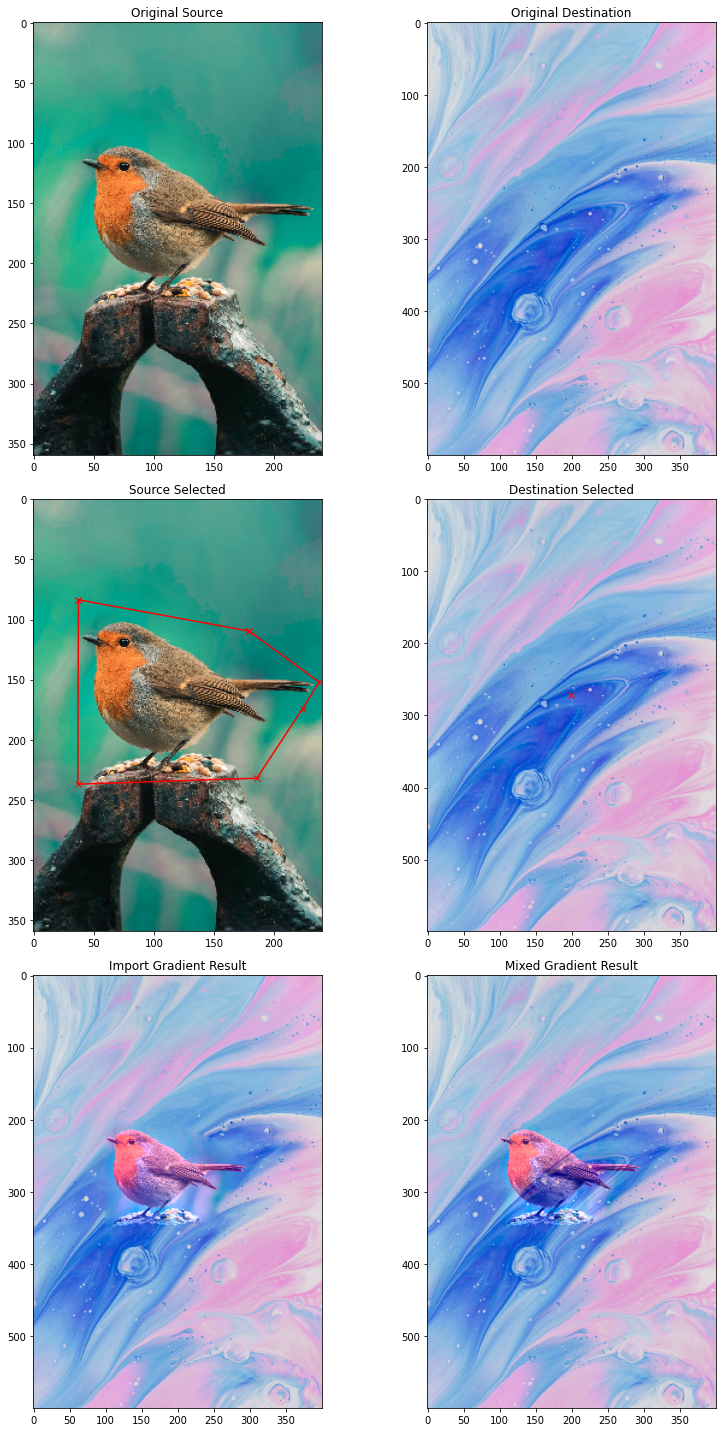

In [20]:
%matplotlib inline

if RUN_INCLUDE_GRADIENT:
    plot_images(
        images=[src_im, dst_im, src_im, dst_im, import_grad_im, mix_grad_im],
        paths=[None, None, src_path, [(dst_loc[0], dst_loc[1])], None, None],
        titles=[
            'Original Source',
            'Original Destination',
            'Source Selected',
            'Destination Selected',
            'Import Gradient Result',
            'Mixed Gradient Result'
        ],
        figsize=(12, 20),
        subplot=(3, 2)
    )

## Additional Tasks

### Texture Flattening

In [21]:
def flatten_grad_fun(im, edge_im, point):
    if not valid_index(im, point):
        raise ValueError(f'Selected point is not within image: point={point}, image shape={im.shape}')
    
    threshold = 127 if edge_im.dtype == np.uint8 else 0.5
    center = im[point[1], point[0]]
    
    grad = 0
    for nb in get_neighbours(point):
        if valid_index(im, nb):
            if edge_im[point[1], point[0]] > threshold or edge_im[nb[1], nb[0]] > threshold:
                grad += float(center) - float(im[nb[1], nb[0]])
                
    return grad

In [22]:
%matplotlib notebook
matplotlib.use("TkAgg")

if RUN_TEXTURE_FLATTENING:

    # im = read_image('bird.jpg', size=(270, 400))
    man_im = read_image('man.jpg', size=(320, 400))

    edge_im = cv.Canny(man_im, 150, 200, L2gradient=True)

    man_path = get_image_path_from_user(man_im, hint='Select region to flatten')

    points = find_all_enclosed_points(man_path)

    A = lapl_matrix(points).tocsr()

    flatten_im = np.copy(man_im)
    for channel in range(man_im.shape[2]):
        channel_im = man_im[:, :, channel]

        def channel_grad_fun(point):
            return flatten_grad_fun(channel_im, edge_im, point)

        b = grad_matrix(channel_im, points, grad_fun=channel_grad_fun)

        flatten_colors = spsolve(A, b)
        
        assign_color(flatten_im, channel, points, flatten_colors)

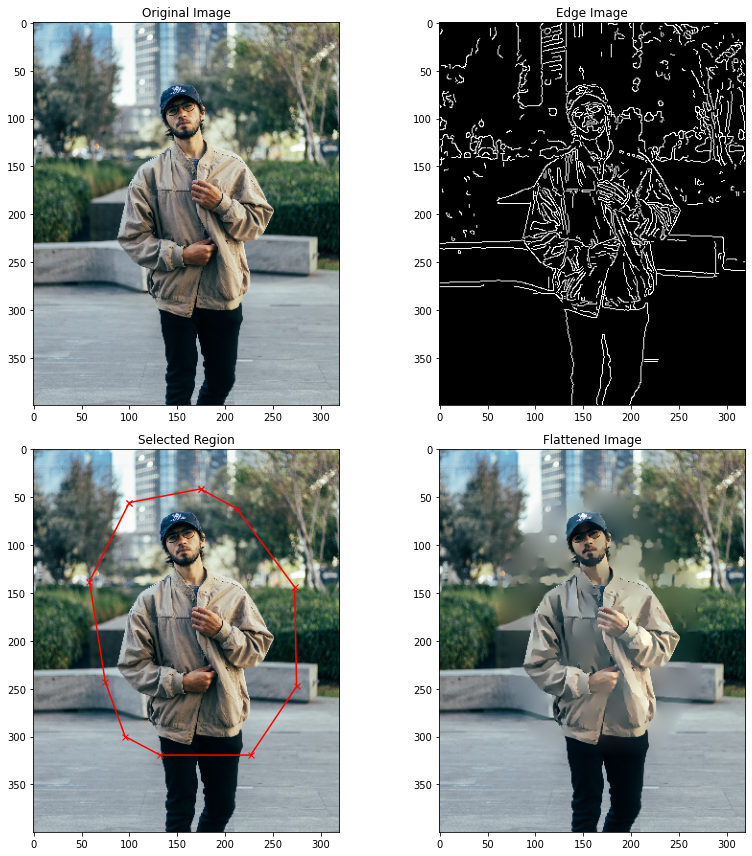

In [23]:
%matplotlib inline

if RUN_TEXTURE_FLATTENING:
    plot_images(
        images=[man_im, edge_im, man_im, flatten_im],
        paths=[None, None, man_path, None],
        titles=['Original Image', 'Edge Image', 'Selected Region', 'Flattened Image'],
        figsize=(12, 12),
        subplot=(2, 2)
    )

### Local Illumination Changes

In [24]:
def illuminate_grad_fun(im, point, avg_grad_norm, alpha=0.2, beta=0.2):
    if not valid_index(im, point):
        raise ValueError(f'point not in valid image range: point={point}, image={im.shape}')
    
    center = im[point[1], point[0]]
    grad = 0
    for nb in get_neighbours(point):
        if valid_index(im, nb):
            curr_grad = float(center) - float(im[nb[1], nb[0]])
            if not np.allclose(curr_grad, 0):
                grad += np.power((alpha * avg_grad_norm), beta) * np.power(abs(curr_grad), -beta) * curr_grad
    return grad

In [25]:
def calc_avg_grad_norm(im, points):
    grad_sum = 0
    total = 0
    for point in points:
        center = float(im[point[1], point[0]])
        for nb in get_neighbours(point):
            if valid_index(im, nb):
                grad_sum += abs(center - float(im[nb[1], nb[0]]))
                total += 1
    return grad_sum / total

In [26]:
%matplotlib notebook
matplotlib.use("TkAgg")

if RUN_LOCAL_ILLUMINATION_CHANGES:

    flower_im = read_image('flower.jpg')

    flower_path = get_image_path_from_user(flower_im, hint='Select region to illuminate')

    points = find_all_enclosed_points(flower_path)

    A = lapl_matrix(points).tocsr()

    illuminated_im = np.copy(flower_im)

    for channel in range(flower_im.shape[2]):
        channel_im = flower_im[:, :, channel]
        avg_grad_norm = calc_avg_grad_norm(channel_im, points)

        def channel_grad_fun(point):
            return illuminate_grad_fun(channel_im, point, avg_grad_norm, alpha=0.2, beta=0.2)

        b = grad_matrix(channel_im, points, grad_fun=channel_grad_fun)

        illuminated_color = spsolve(A, b)
        
        assign_color(illuminated_im, channel, points, illuminated_color)

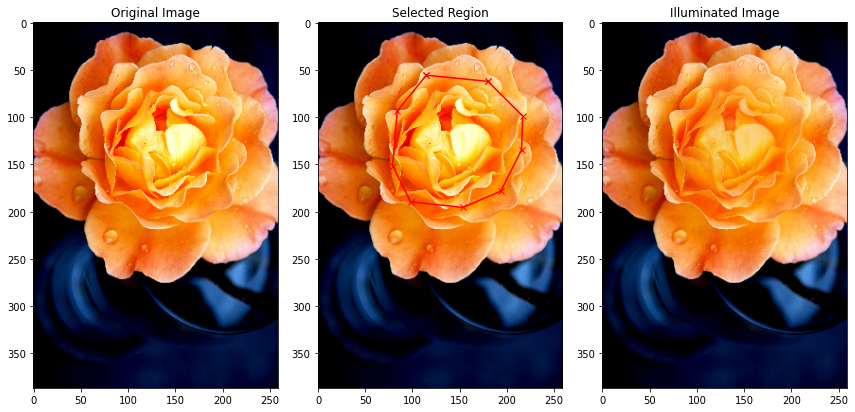

In [27]:
%matplotlib inline

if RUN_LOCAL_ILLUMINATION_CHANGES:
    plot_images(
        images=[flower_im, flower_im, illuminated_im],
        paths=[None, flower_path, None, None],
        titles=['Original Image', 'Selected Region', 'Illuminated Image'],
        figsize=(12, 16),
        subplot=(1, 3)
    )

### Local Color Change

In [28]:
%matplotlib notebook
matplotlib.use("TkAgg")

if RUN_LOCAL_COLOR_CHANGE:

    rose_im = read_image('rose.jpg')

    rose_path = get_image_path_from_user(rose_im, hint='Select region to keep color')

    points = find_all_enclosed_points(rose_path)

    A = lapl_matrix(points).tocsr()

    gray_im = cv.cvtColor(rose_im, cv.COLOR_RGB2GRAY)

    isolated_im = cv.merge([gray_im, gray_im, gray_im])

    for channel in range(rose_im.shape[2]):
        channel_im = rose_im[:, :, channel]

        def channel_grad_fun(point):
            return calc_import_grad(channel_im, point)

        b = grad_matrix(gray_im, points, grad_fun=channel_grad_fun)

        colors = spsolve(A, b)
        
        assign_color(isolated_im, channel, points, colors)

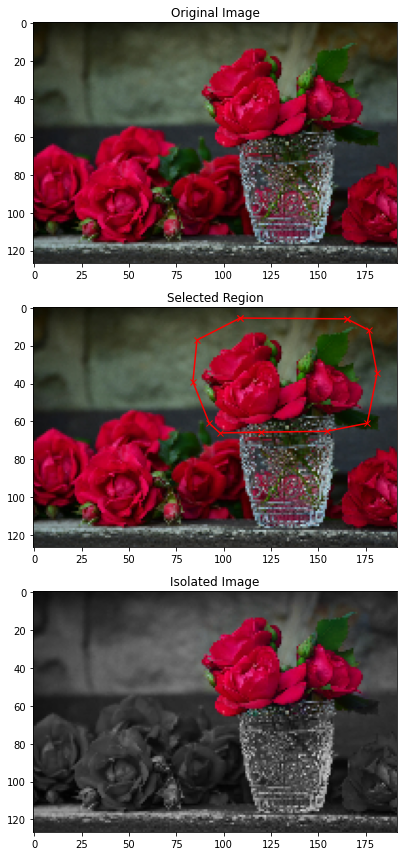

In [29]:
%matplotlib inline

if RUN_LOCAL_COLOR_CHANGE:
    plot_images(
        images=[rose_im, rose_im, isolated_im],
        paths=[None, rose_path, None],
        titles=['Original Image', 'Selected Region', 'Isolated Image'],
        figsize=(8, 12),
        subplot=(3, 1)
    )

### Seamless Tiling

In [30]:
def calc_tile_color(im, point, nb):
    wrap_nb0 = nb[0] % im.shape[1]
    wrap_nb1 = nb[1] % im.shape[0]
    return (float(im[point[1], point[0]]) + float(im[wrap_nb1, wrap_nb0])) / 2.0

In [31]:
%matplotlib notebook
matplotlib.use("TkAgg")


if RUN_SEAMLESS_TILING:
    
    tile_im = read_image('tile.jpg')

    tile_path = [(0, 0), (0, tile_im.shape[0]-1), (tile_im.shape[1]-1, tile_im.shape[0]-1), (tile_im.shape[1]-1, 0)]

    points = find_all_enclosed_points(tile_path)

    A = lapl_matrix(points).tocsr()

    seamless_tile_im = np.zeros_like(tile_im)
    for channel in range(tile_im.shape[2]):
        channel_im = tile_im[:, :, channel]

        def channel_grad_fun(point):
            return calc_import_grad(channel_im, point)

        b = grad_matrix(channel_im, points, grad_fun=channel_grad_fun, boundary_fun=calc_tile_color)

        colors = spsolve(A, b)
        
        assign_color(seamless_tile_im, channel, points, colors)

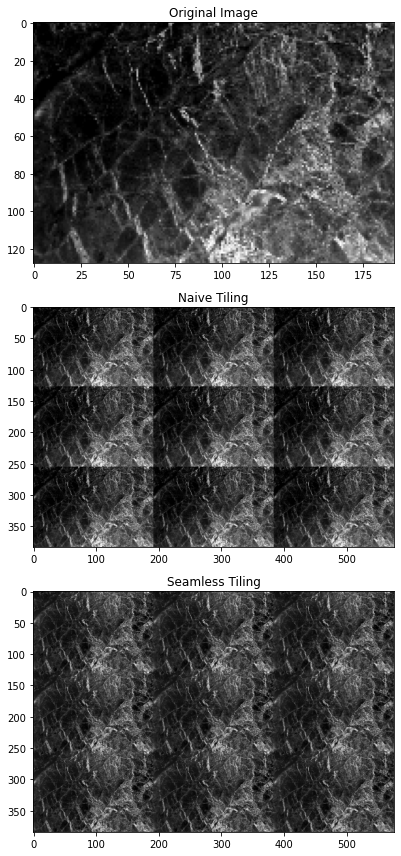

In [32]:
%matplotlib inline

if RUN_SEAMLESS_TILING:
    plot_images(
        images=[tile_im, np.tile(tile_im, (3, 3, 1)), np.tile(seamless_tile_im, (3, 3, 1))],
        paths=[None, None, None],
        titles=['Original Image', 'Naive Tiling', 'Seamless Tiling'],
        figsize=(8, 12),
        subplot=(3, 1)
    )